In [44]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express.colors as color
%matplotlib inline

## 1. Data

In [45]:
bicycle = pd.read_csv('_data/train.csv')
t_bicycle = pd.read_csv('_data/test.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [46]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []
    
    for date in dataframe.date_time :
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
        
    return year, month, day

year, month, day = seperate_datetime(bicycle)

bicycle['year'] = year
bicycle['month'] = month
bicycle['day'] = day
bicycle['weekday'] = pd.to_datetime(bicycle['date_time']).dt.weekday
bicycle.drop('date_time', axis=1, inplace=True)

bicycle.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3


In [47]:
year, month, day = seperate_datetime(t_bicycle)

t_bicycle['year'] = year
t_bicycle['month'] = month
t_bicycle['day'] = day
t_bicycle['weekday'] = pd.to_datetime(t_bicycle['date_time']).dt.weekday
t_bicycle.drop('date_time', axis=1, inplace=True)

In [48]:
bicycle['weekend'] = bicycle['weekday'] >= 5
t_bicycle['weekend'] = t_bicycle['weekday'] >= 5

## 2.EDA

### 데이터 분포

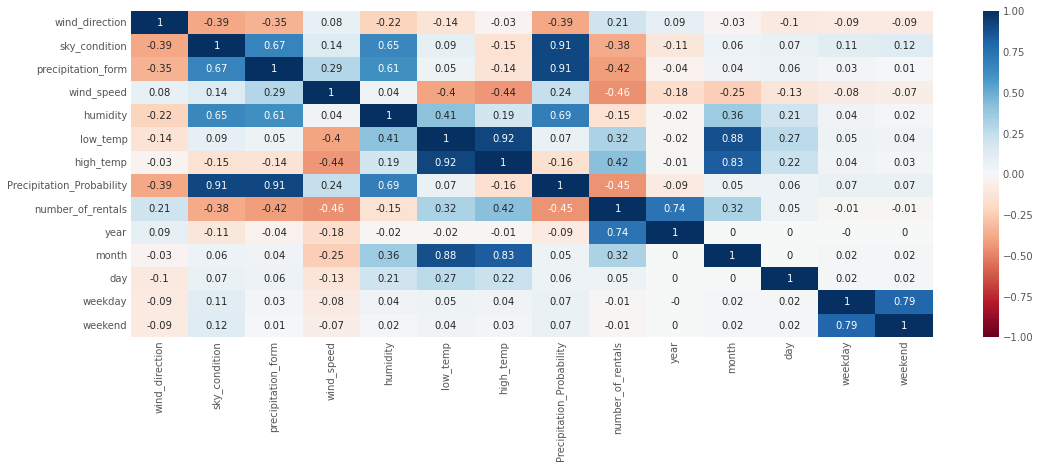

In [49]:
corr = np.round(bicycle.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(16,6))
hm = sns.heatmap(corr,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

- wind_direction: 풍향 (degree)
- sky_condition : 맑음(1), 구름많음(3), 흐림(4)
- precipitation_form : 강수 형태 / 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

In [50]:
# masked_corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool))
# corr_rank = np.abs(masked_corr[masked_corr < 1]).unstack().sort_values(ascending = False).to_frame()
# corr_rank.dropna(inplace=True)

In [51]:
corr_dic = {}
for col in corr.columns:
    corr_dic[col] = np.abs(corr).loc[:,col].sort_values(ascending=False)

In [52]:
def corr_compare(*array):
    col = corr.columns
    print(col)
    for n in array :
        print(corr_dic.get(col[n]))

In [58]:
corr_compare(1)

Index(['wind_direction', 'sky_condition', 'precipitation_form', 'wind_speed',
       'humidity', 'low_temp', 'high_temp', 'Precipitation_Probability',
       'number_of_rentals', 'year', 'month', 'day', 'weekday', 'weekend'],
      dtype='object')
sky_condition                1.00
Precipitation_Probability    0.91
precipitation_form           0.67
humidity                     0.65
wind_direction               0.39
number_of_rentals            0.38
high_temp                    0.15
wind_speed                   0.14
weekend                      0.12
year                         0.11
weekday                      0.11
low_temp                     0.09
day                          0.07
month                        0.06
Name: sky_condition, dtype: float64


### 데이터 간소화

독립성이 부족하거나 의미가 없는 데이터들을 통합 및 폐합

- 온도 통합 (평균)
- 강수확률 vs 강수형태 vs 구름 / 강수확률 + 구름
- 의미없는 데이터 삭제(일, 요일, 주말)
- 의미를 알기 어려운 데이터 삭제(풍향)

In [55]:
bicycle_new = bicycle.copy()
t_bicycle_new = t_bicycle.copy()

for D in [bicycle_new, t_bicycle_new]:

    #온도 통합 (평균)
    D['temp'] = (D['high_temp'] + D['low_temp']) / 2
    D.drop(['high_temp', 'low_temp'], axis=1, inplace=True)

    #강수확률 vs 강수형태 vs 구름 / 강수확률 우선테스트
    D.drop(['precipitation_form'], axis=1, inplace=True)

    #의미없는 데이터 삭제(일, 요일, 주말)
    D.drop(['day','weekday', 'weekend'], axis=1, inplace=True)

    #의미를 알기 어려운 데이터 삭제(풍향)
    D.drop(['wind_direction'], axis=1, inplace=True)

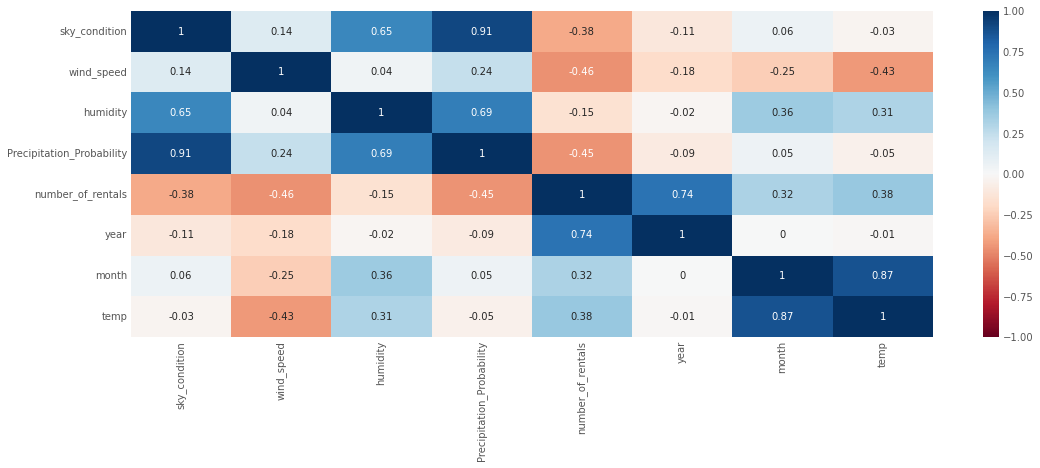

In [56]:
corr2 = np.round(bicycle_new.corr(),2)
mask = np.triu(np.ones_like(corr2, dtype=np.bool))
plt.figure(figsize=(16,6))
hm = sns.heatmap(corr2,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

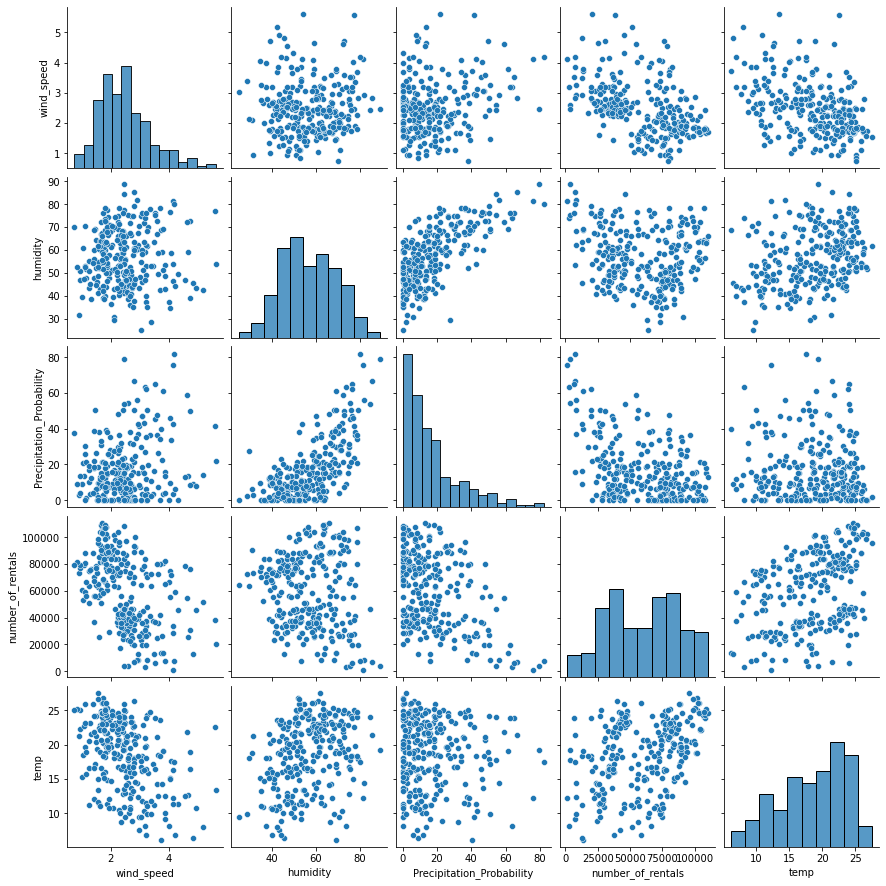

In [13]:
sns.pairplot(bicycle_new)

In [14]:
desc = bicycle_new.describe()

In [15]:
desc

,wind_speed,humidity,Precipitation_Probability,number_of_rentals,temp
count,273.000000,273.000000,273.000000,273.000000,273.000000
mean,2.480963,56.745491,16.878103,59574.978022,18.589991
std,0.884397,12.351268,16.643772,27659.575774,5.052679
min,0.753000,24.831000,0.000000,1037.000000,6.197500
25%,1.820000,47.196000,4.054000,36761.000000,15.083500
50%,2.411000,55.845000,12.162000,63032.000000,19.398000
75%,2.924000,66.419000,22.973000,81515.000000,22.837500
max,5.607000,88.885000,82.162000,110377.000000,27.523000


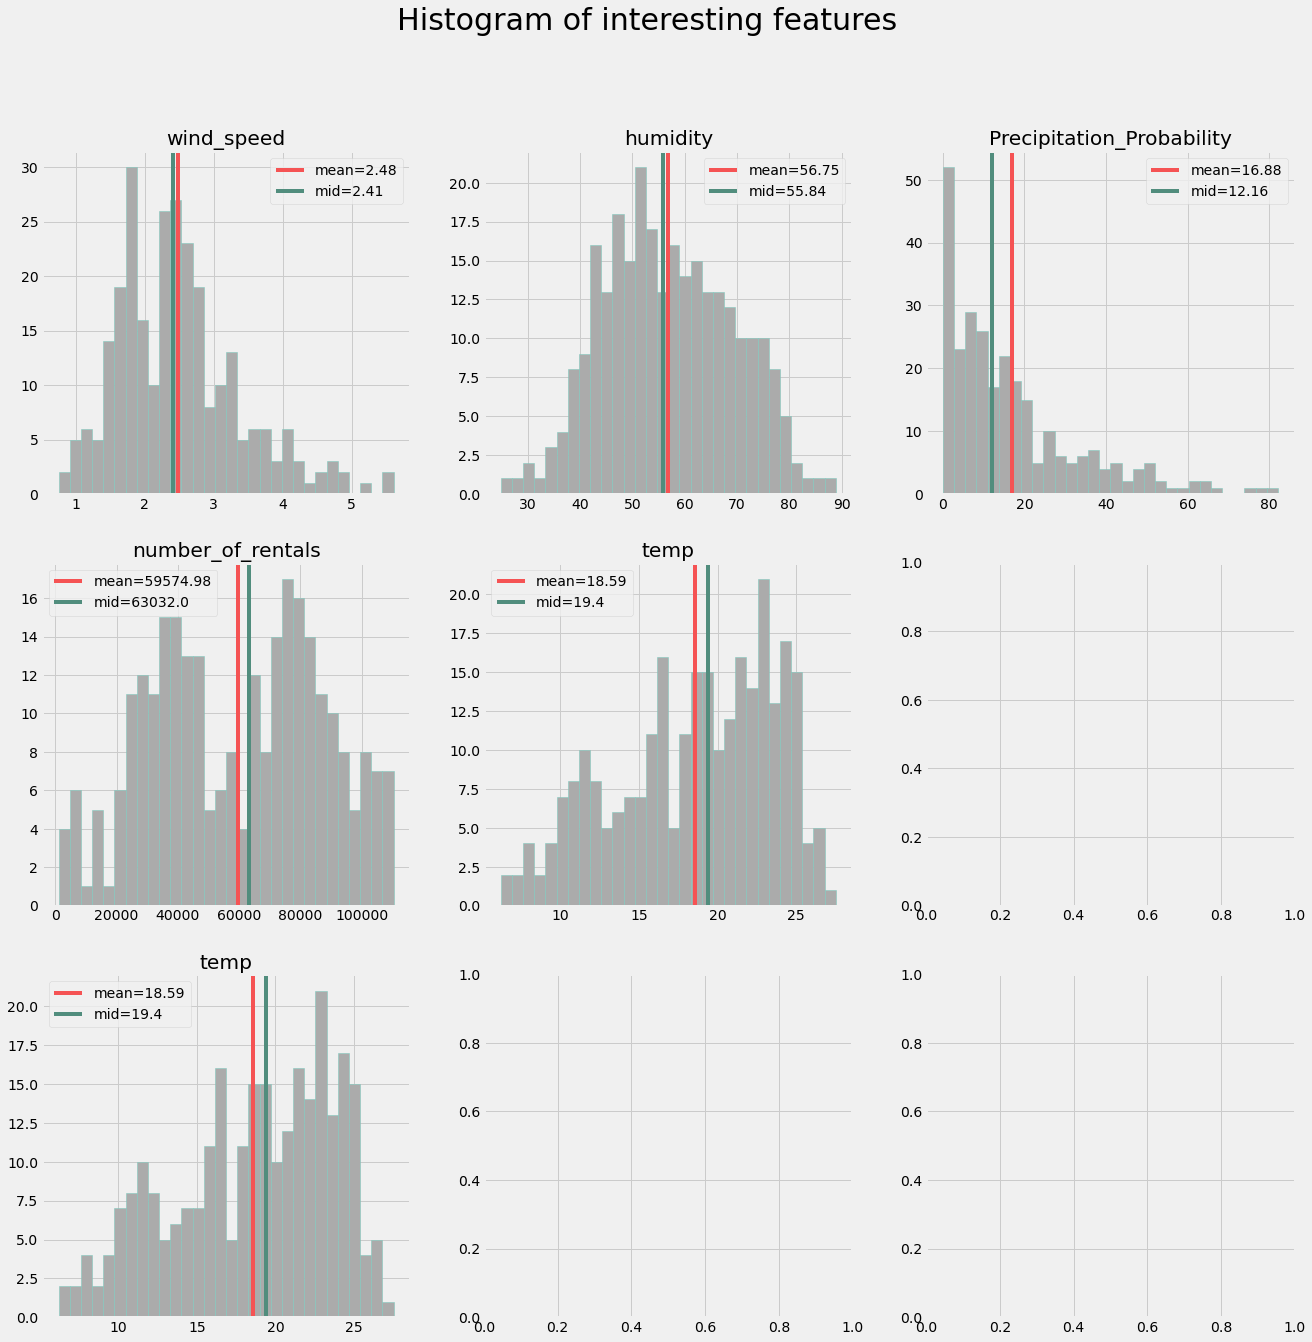

In [20]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(3, 3, figsize=(20,20))

fig.suptitle('Histogram of interesting features', fontsize=30)

col_i = 0
for i in range(3):
    for j in range(3):
        col_name = bicycle_new.columns[col_i]
        mean = desc[col_name]['mean']
        mid = desc[col_name]['50%']
        ax[i][j].hist(bicycle_new[col_name], 
                      bins=30, 
                      color='#ababab',
                      edgecolor='#7bcabf')
        ax[i][j].set_title(bicycle_new.columns[col_i])
        ax[i][j].axvline(mean,
                         c='#f55354',
                         label=f'mean={round(mean,2)}'
                        )
        ax[i][j].axvline(mid,
                         c='#518d7d',
                         label=f'mid={round(mid,2)}'
                        )
        ax[i][j].legend()
        
        if col_i == 4:
            break
        col_i += 1

## 3. Model

In [21]:
X = bicycle_new.drop('number_of_rentals', axis=1)
y = bicycle_new['number_of_rentals']

### Scale

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

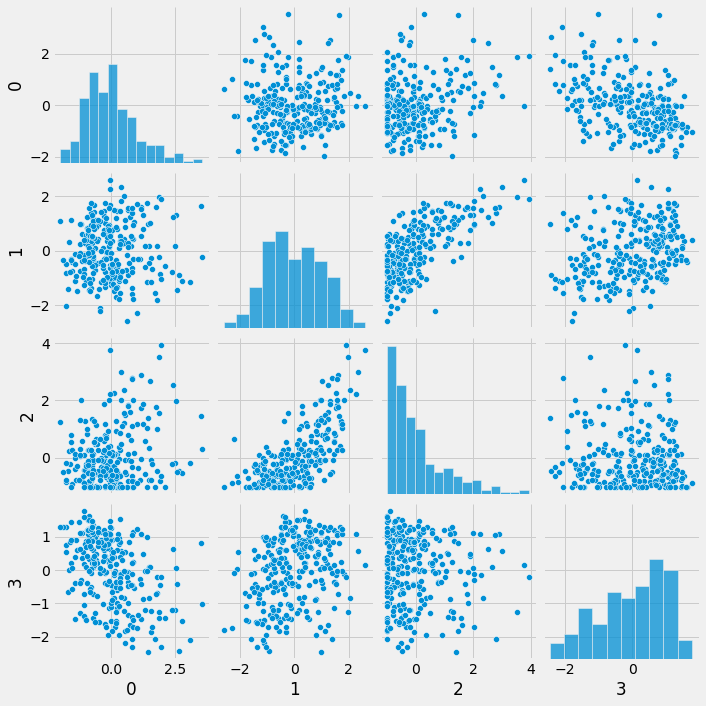

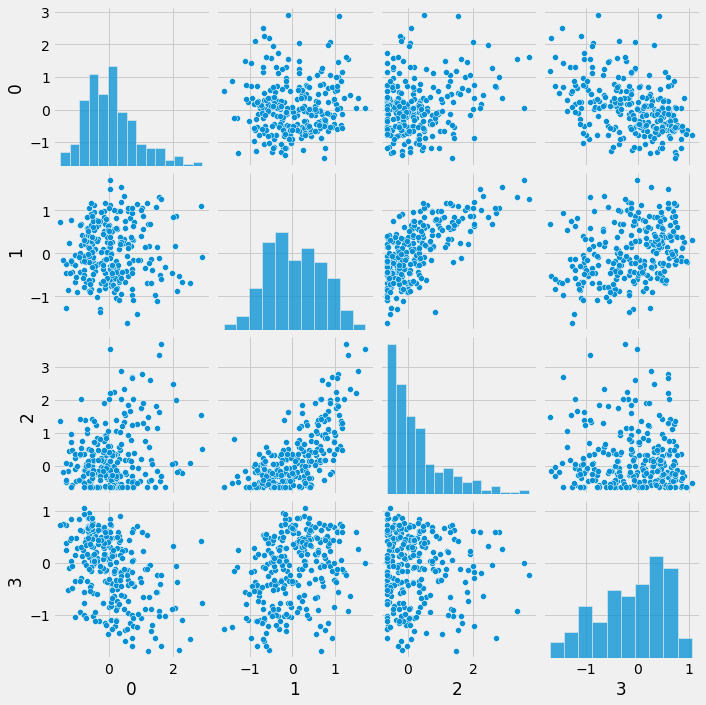

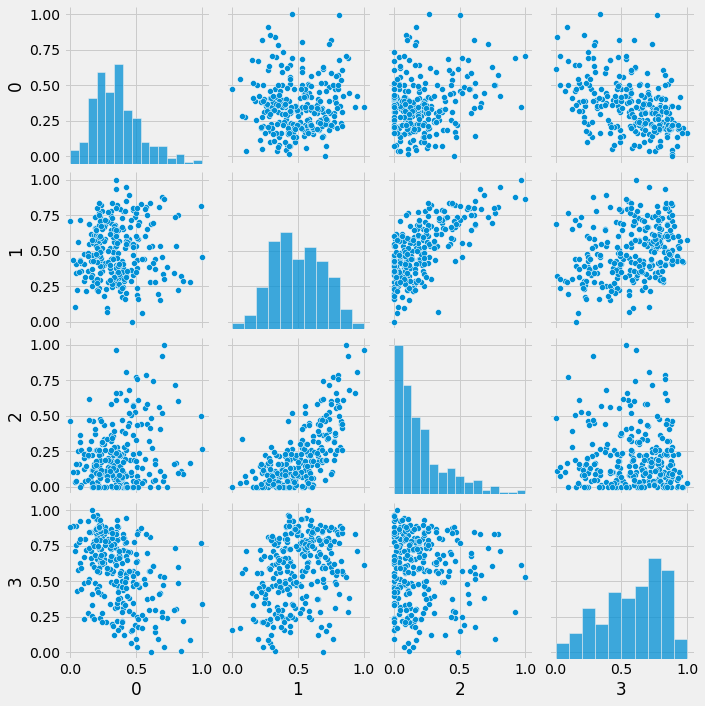

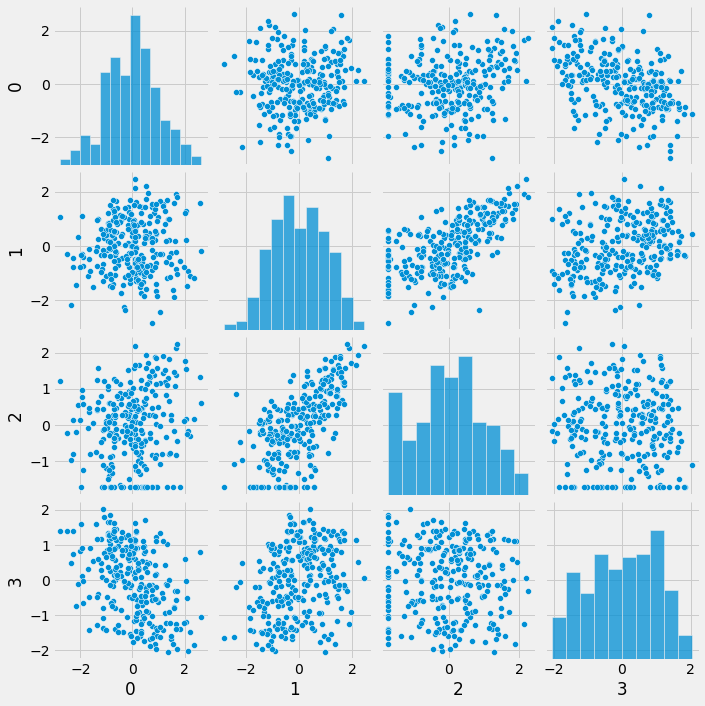

In [23]:
for scaler in [StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer] :
    scaled_X = pd.DataFrame(scaler().fit_transform(X))
    sns.pairplot(scaled_X)

In [24]:
scaler = PowerTransformer()
scaled_X = scaler.fit_transform(X)

In [25]:
t_scaled_X = scaler.transform(t_bicycle_new)

### Fit

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(scaled_X, y)

LinearRegression()

### Predict

In [27]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [28]:
y_hat = model.predict(scaled_X)

nmae = NMAE(y, y_hat)

print(f'모델 NMAE : {nmae}')

모델 NMAE : 0.6071928278133657


### CV

In [29]:
##### from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

#for i in range(2,10):
    
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

scores = []

model = LinearRegression()

for train_index, test_index in tscv.split(scaled_X, y):
    train_X = scaled_X[train_index]
    test_X = scaled_X[test_index]
    train_y = y[train_index]
    test_y = y[test_index]

    model.fit(train_X, train_y)

    y_pred = model.predict(test_X)

    scores.append(NMAE(test_y, y_pred))

#print(i, 
np.mean(scores)
#     )

model.fit(scaled_X, y)
y_hat = model.predict(scaled_X)
nmae = NMAE(y, y_hat)
print(f'모델 NMAE : {nmae}')

모델 NMAE : 0.6071928278133657


## 4.Evaluate Model

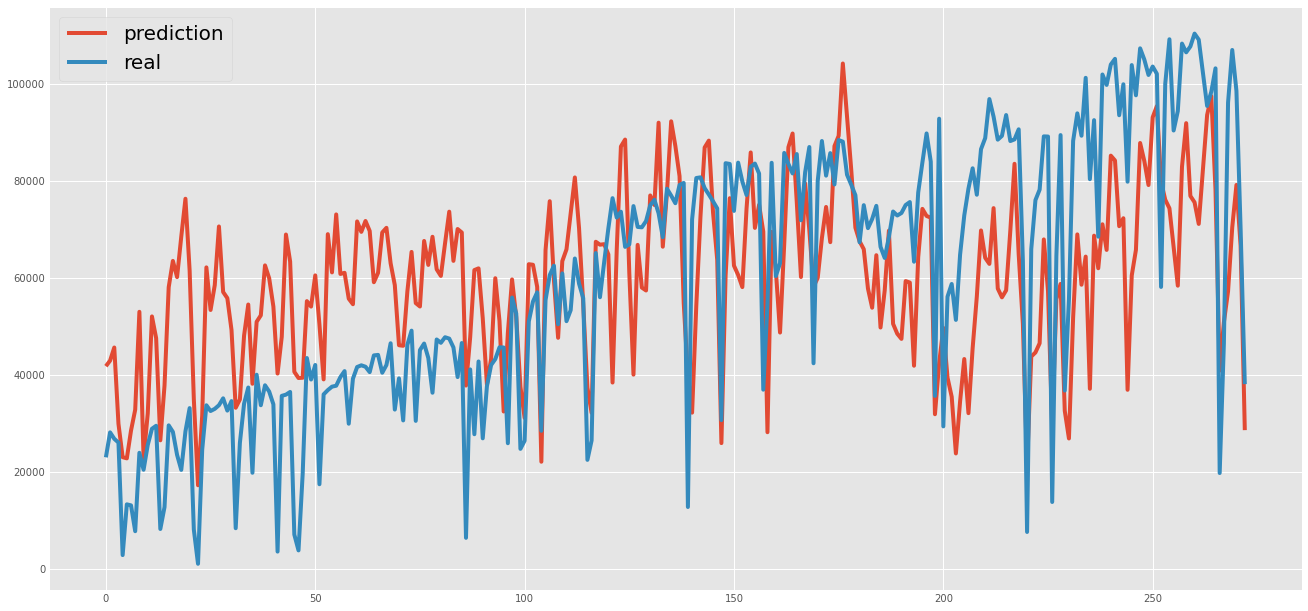

In [30]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(y_hat, label='prediction')
plt.plot(y, label='real')
plt.legend(fontsize=20)
plt.show()

## 5.Submission

In [31]:
submission = pd.read_csv('_data/sample_submission.csv')

In [32]:
result = model.predict(t_scaled_X)

In [33]:
submission['number_of_rentals'] = result

In [379]:
submission.to_csv('_result/1.Feature_importance.csv', index=False)

In [34]:
submission

,date_time,number_of_rentals
0,2021-04-01,44130.188893
1,2021-04-02,42550.985451
2,2021-04-03,39859.892196
3,2021-04-04,27408.736836
4,2021-04-05,69265.987989
5,2021-04-06,56406.189844
6,2021-04-07,73160.972761
7,2021-04-08,66042.991301
8,2021-04-09,85743.770496
9,2021-04-10,65798.864822
